# Multi-Factor Investing 
*An Analysis of Fama and French 5 Faktor Model with Momentum on Several Funds on a 10-year time horizon*

In [27]:
import pandas as pd
import numpy as np
import requests
import json
from PIL import Image
from lxml import etree
import sqlite3
import yfinance as yf
import matplotlib.pyplot as plt
from matplotlib.dates import YearLocator, DateFormatter
import statsmodels.api as sm
import datetime as dt
import seaborn as sns
import warnings
from scipy import stats
from bs4 import BeautifulSoup
import os
import mplfinance as mpf
from datetime import datetime, timedelta

## I. Establishment of ESG Factor 

Diversified portfolio
1. IVV: iShares Core S&P 500 ETF
2. IJH: iShares Core S&P Mid-Cap ETF
3. IJR: iShares Core S&P Small-Cap ETF

##### ETF data

In [28]:
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.options.mode.chained_assignment = None

def preprocess(asset_name, start_date="2014-11-01", end_date="2024-11-01"):
    # Create 'data' folder if it doesn't exist
    data_folder = '__data'
    os.makedirs(data_folder, exist_ok=True)
    # Define the CSV filename
    csv_filename = os.path.join(data_folder, f'{asset_name.lower()}_data.csv')
    # Check if the CSV file already exists
    if not os.path.exists(csv_filename):
        # Download the data
        asset_data = yf.download(asset_name, start=start_date, end=end_date)
        # Reset the index to make the date a column
        asset_reset = asset_data.reset_index()
        # Rename the 'Date' column (which is now the first column)
        asset_reset = asset_reset.rename(columns={'Date': 'Date'})
        # Save to CSV file, skipping the first row (header) and without including the index
        asset_reset.to_csv(csv_filename, index=False, header=False)
    # Read the CSV file
    asset_from_csv = pd.read_csv(csv_filename, names=['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'])
    return asset_from_csv

def process(df):
    # Convert the 'Date' column to datetime and set it as the index
    df['Date'] = pd.to_datetime(df['Date'])
    df.set_index('Date', inplace=True)
    # Sort the index in ascending order
    df = df.sort_index()
    # Ensure we have the required columns
    required_columns = ['Open', 'High', 'Low', 'Close']
    if not all(col in df.columns for col in required_columns):
        raise ValueError(f"DataFrame is missing one or more required columns: {required_columns}")
    # Drop any rows with missing data in the required columns
    df = df.dropna(subset=required_columns)
    return df

def plot_last_100(df, title):
    df100 = df.tail(100)
    mpf.plot(df100[['Open', 'High', 'Low', 'Close']], type='candle', style='charles', 
             title=f'Price Movement of {title} (last 100 days)', 
             ylabel='Price', volume=False, figsize=(20, 10), figscale=1.5)
    plt.show()

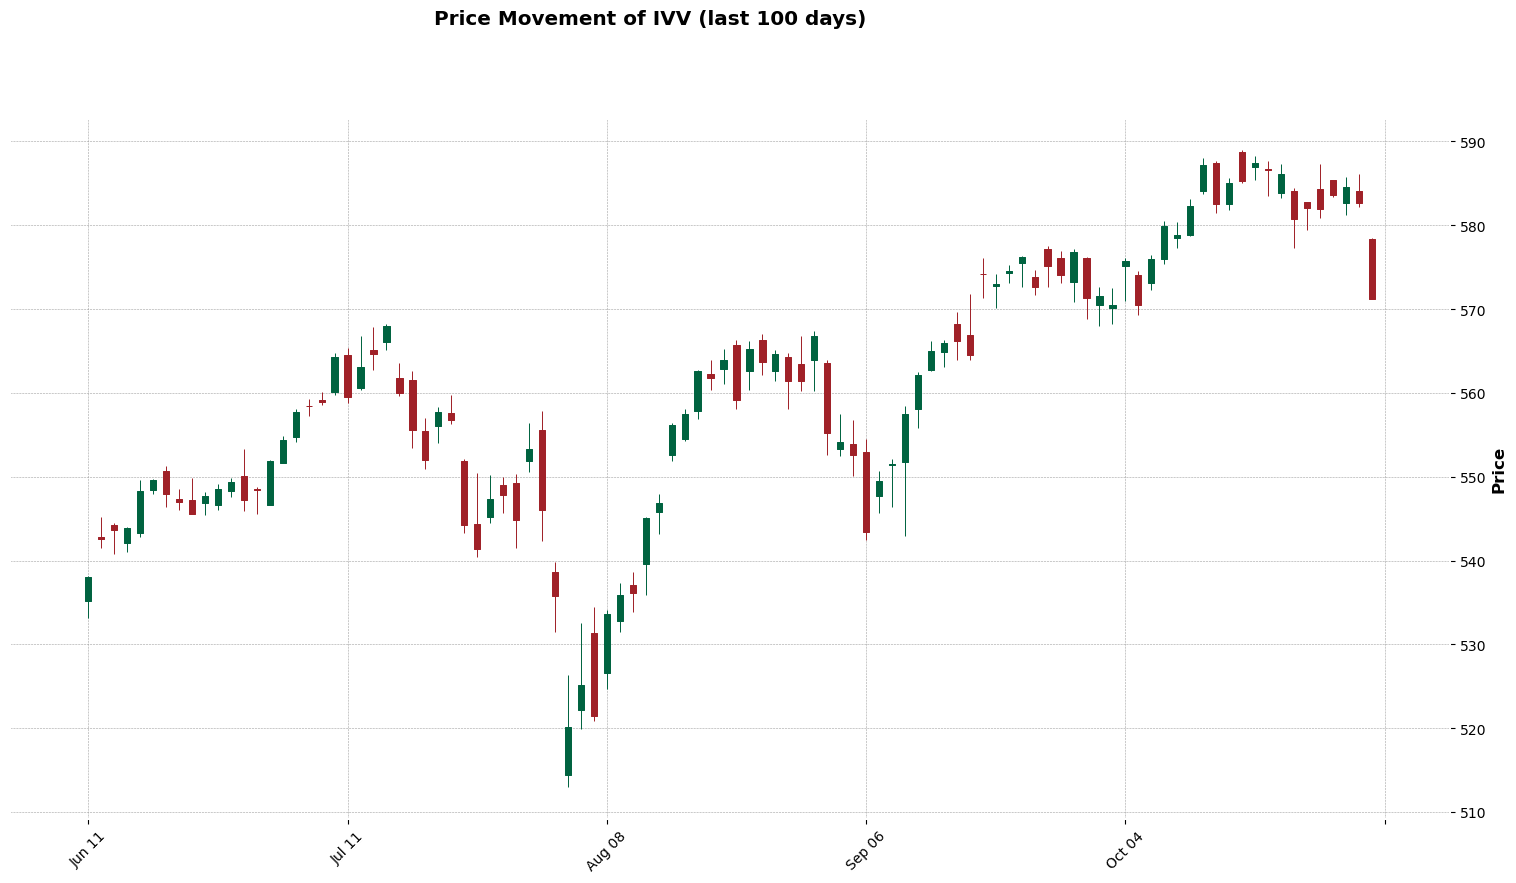

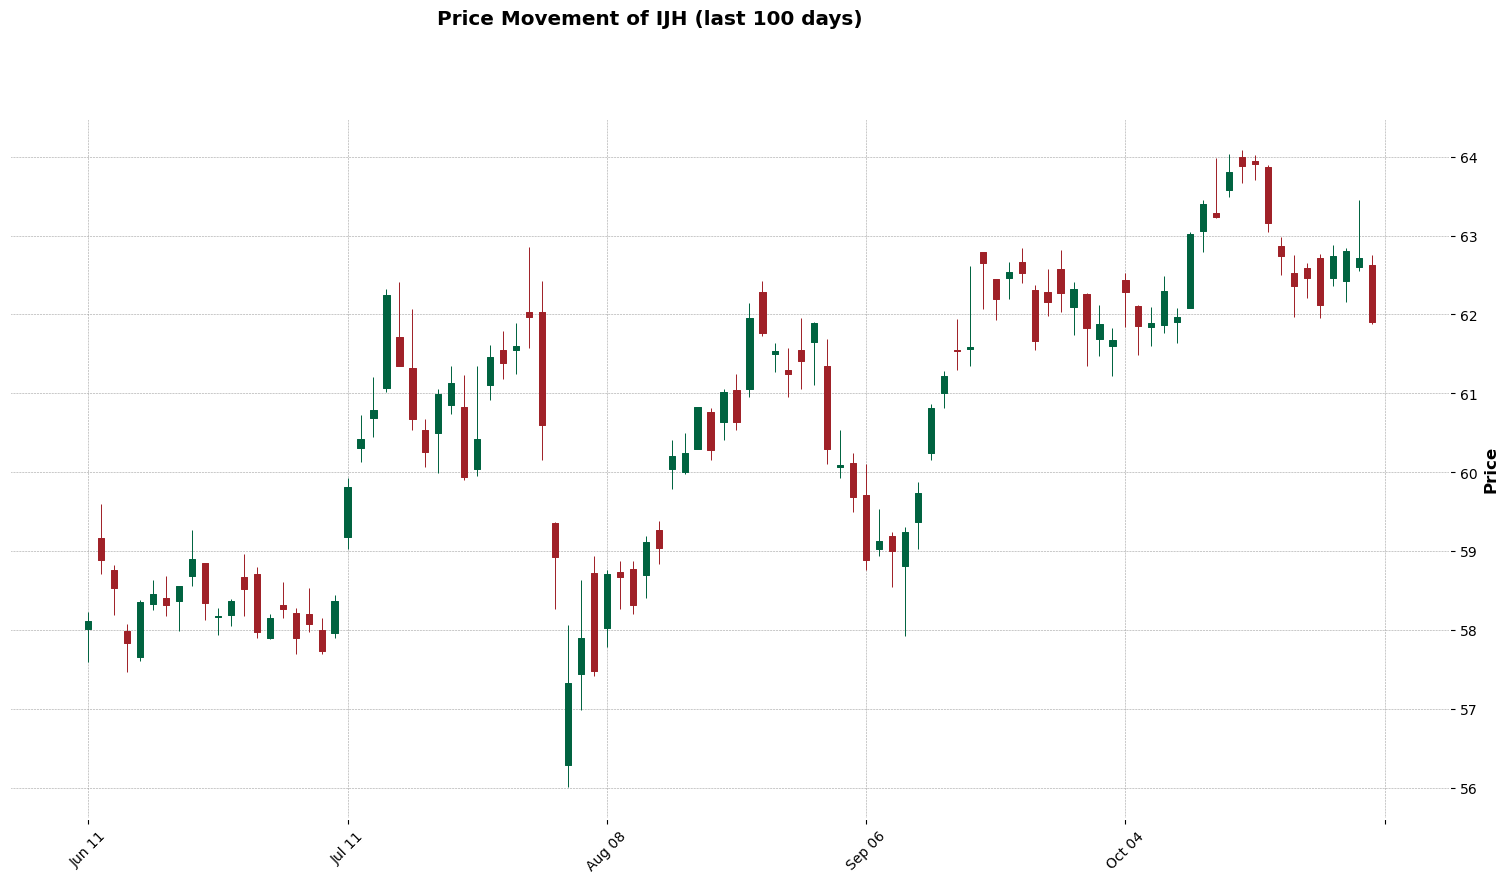

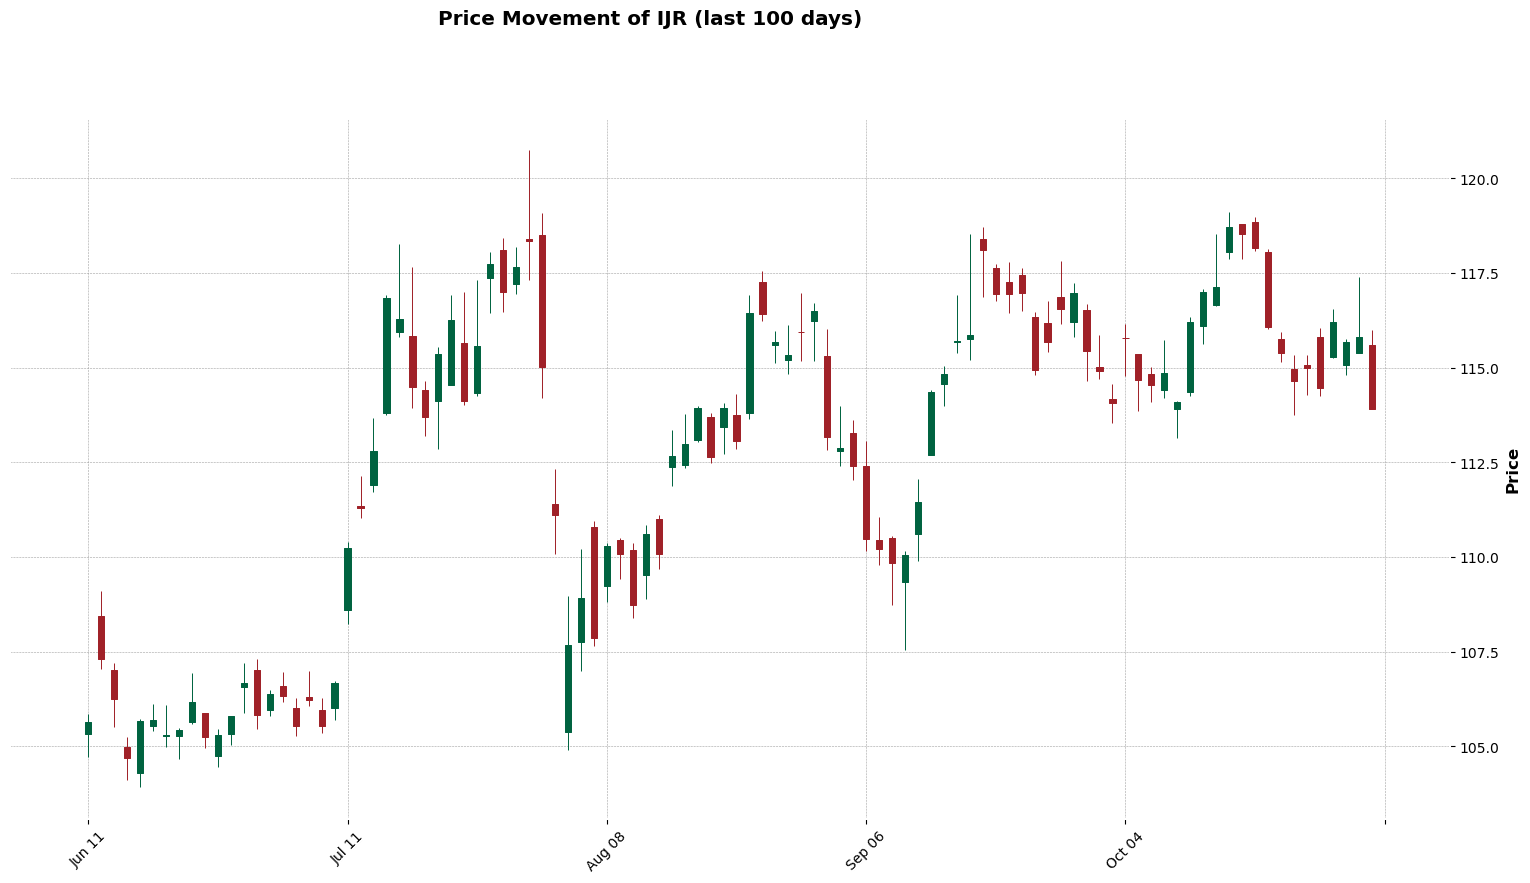

In [29]:
# Download dataset and save as csv
ivv = preprocess("IVV")
ijh = preprocess("IJH")
ijr = preprocess("IJR")

# Process each dataset
ivv = process(ivv)
ijh = process(ijh)
ijr = process(ijr)

# Plot each dataset
ivv_plot = plot_last_100(ivv, "IVV")
ijh_plot = plot_last_100(ijh, "IJH")
ijr_plot = plot_last_100(ijr, "IJR")

In [30]:
# Add column names
def add_column_names(df):
    column_names = ['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']
    df.columns = column_names
    return df

In [31]:
ivv_df = pd.read_csv("__data/ivv_data.csv")
ivv_df = add_column_names(ivv_df)
ivv_df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-11-04,202.580002,202.929993,201.389999,202.429993,169.396774,5309000
1,2014-11-05,203.910004,203.949997,202.800003,203.729996,170.484665,5668700
2,2014-11-06,203.720001,204.619995,202.979996,204.500000,171.129013,4176600
3,2014-11-07,204.500000,204.940002,203.970001,204.759995,171.346573,3614700
4,2014-11-10,204.720001,205.399994,204.479996,205.300003,171.798477,3223900


In [32]:
ijh_df = pd.read_csv("__data/ijh_data.csv")
ijh_df = add_column_names(ijh_df)
ijh_df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-11-04,28.282000,28.364000,28.148001,28.266001,24.260365,4128500
1,2014-11-05,28.448000,28.468000,28.238001,28.351999,24.334181,4001500
2,2014-11-06,28.365999,28.566000,28.340000,28.566000,24.517851,5107500
3,2014-11-07,28.524000,28.620001,28.444000,28.590000,24.538456,3637500
4,2014-11-10,28.600000,28.728001,28.584000,28.670000,24.607111,2990000


In [33]:
ijr_df = pd.read_csv("__data/ijr_data.csv")
ijr_df = add_column_names(ijr_df)
ijr_df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-11-04,55.549999,55.755001,55.224998,55.494999,48.056053,2054600
1,2014-11-05,55.904999,55.904999,55.410000,55.634998,48.177299,1011000
2,2014-11-06,55.680000,55.794998,55.404999,55.785000,48.307182,1085200
3,2014-11-07,55.775002,55.805000,55.400002,55.794998,48.315849,1881000
4,2014-11-10,55.830002,56.014999,55.654999,55.985001,48.480381,1430200


##### ESG data

In [34]:
### PASTE ESG CODE HERE ###



## II. Factor Analysis 

### 1. Data Import and Preprocessing

#### 1.1 Import data

##### 1.2 Fama and French 5-factor data
15-year time window (starting from 2024-10-02)

In [35]:
ff5 = pd.read_csv("__data/F-F_Research_Data_5_Factors_2x3_daily.CSV", skiprows=2, index_col=0)

# Convert the index to datetime 
ff5.index = pd.to_datetime(ff5.index, format='%Y%m%d')

# Remove any potential whitespace in column names
ff5.columns = ff5.columns.str.strip()

# Convert data to numeric, replacing any non-numeric values with NaN
for col in ff5.columns:
    ff5[col] = pd.to_numeric(ff5[col], errors='coerce')

# Drop observations older than 2009-10-02
ff5 = ff5[ff5.index >= '2009-10-02']

# Create a new "Date" column from the index
ff5["Date"] = ff5.index

# Sort columns
ff5 = ff5[['Date', 'Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'RF']]     

# Drop index
ff5.reset_index(drop=True, inplace=True)

# Display the first few rows of the resulting dataframe
print(ff5.head())

        Date  Mkt-RF   SMB   HML   RMW   CMA   RF
0 2009-10-02   -0.49 -0.31 -0.13 -0.11  0.02  0.0
1 2009-10-05    1.54  0.36  1.81 -0.34  0.38  0.0
2 2009-10-06    1.42  0.52  0.24  0.11 -0.17  0.0
3 2009-10-07    0.28 -0.30  0.58 -0.37 -0.12  0.0
4 2009-10-08    0.82  0.31  0.38  0.84  0.02  0.0


##### 1.3 Tidy and Merge data

In [36]:
#Merge data
def process_and_rename(df, prefix):
    # Ensure 'Date' is a column, not an index
    if 'Date' not in df.columns:
        df = df.reset_index()
    
    # Rename columns
    rename_dict = {
        'Open': f'open_{prefix}',
        'High': f'high_{prefix}',
        'Low': f'low_{prefix}',
        'Close': f'close_{prefix}'
    }
    df = df.rename(columns=rename_dict)
    
    # Ensure Date is datetime
    df['Date'] = pd.to_datetime(df['Date'])
    
    return df[['Date'] + list(rename_dict.values())]

# Process and rename other datasets
ivv = process_and_rename(ivv, 'ivv')
ijh = process_and_rename(ijh, 'ijh')
ijr = process_and_rename(ijr, 'ijr')

# Merge all datasets
data = pd.merge(ivv, ff5, on='Date', how='inner')
data = pd.merge(data, ijh, on='Date', how='inner')
data = pd.merge(data, ijr, on='Date', how='inner')

# Display the first few rows and column names of the resulting dataframe
print(data.head())
print("\nColumns in the merged dataset:")
print(data.columns.tolist())

        Date    open_ivv    high_ivv     low_ivv   close_ivv  Mkt-RF   SMB  \
0 2014-11-03  203.220001  203.789993  202.660004  203.110001   -0.01 -0.30   
1 2014-11-04  202.580002  202.929993  201.389999  202.429993   -0.35 -0.04   
2 2014-11-05  203.910004  203.949997  202.800003  203.729996    0.48 -0.42   
3 2014-11-06  203.720001  204.619995  202.979996  204.500000    0.49  0.06   
4 2014-11-07  204.500000  204.940002  203.970001  204.759995    0.09  0.01   

    HML   RMW   CMA   RF   open_ijh   high_ijh    low_ijh  close_ijh  \
0 -0.06  0.05  0.14  0.0  28.384001  28.520000  28.294001  28.382000   
1 -0.20  0.13  0.03  0.0  28.282000  28.364000  28.148001  28.266001   
2  0.86  0.31  0.73  0.0  28.448000  28.468000  28.238001  28.351999   
3 -0.46  0.11 -0.26  0.0  28.365999  28.566000  28.340000  28.566000   
4  0.47 -0.21  0.06  0.0  28.524000  28.620001  28.444000  28.590000   

    open_ijr   high_ijr    low_ijr  close_ijr  
0  55.970001  56.145000  55.514999  55.700001  
1 

In [37]:
#Len data
len(data)

2473

##### 1.4 Compute Momentum (3, 6 and 12 months) for each Fund

        Date  momentum_12m_ivv  momentum_6m_ivv  momentum_3m_ivv  \
0 2014-11-03               0.0              0.0              0.0   
1 2014-11-04               0.0              0.0              0.0   
2 2014-11-05               0.0              0.0              0.0   
3 2014-11-06               0.0              0.0              0.0   
4 2014-11-07               0.0              0.0              0.0   
5 2014-11-10               0.0              0.0              0.0   
6 2014-11-11               0.0              0.0              0.0   
7 2014-11-12               0.0              0.0              0.0   
8 2014-11-13               0.0              0.0              0.0   
9 2014-11-14               0.0              0.0              0.0   

   momentum_12m_ijh  momentum_6m_ijh  momentum_3m_ijh  momentum_12m_ijr  \
0               0.0              0.0              0.0               0.0   
1               0.0              0.0              0.0               0.0   
2               0.0       

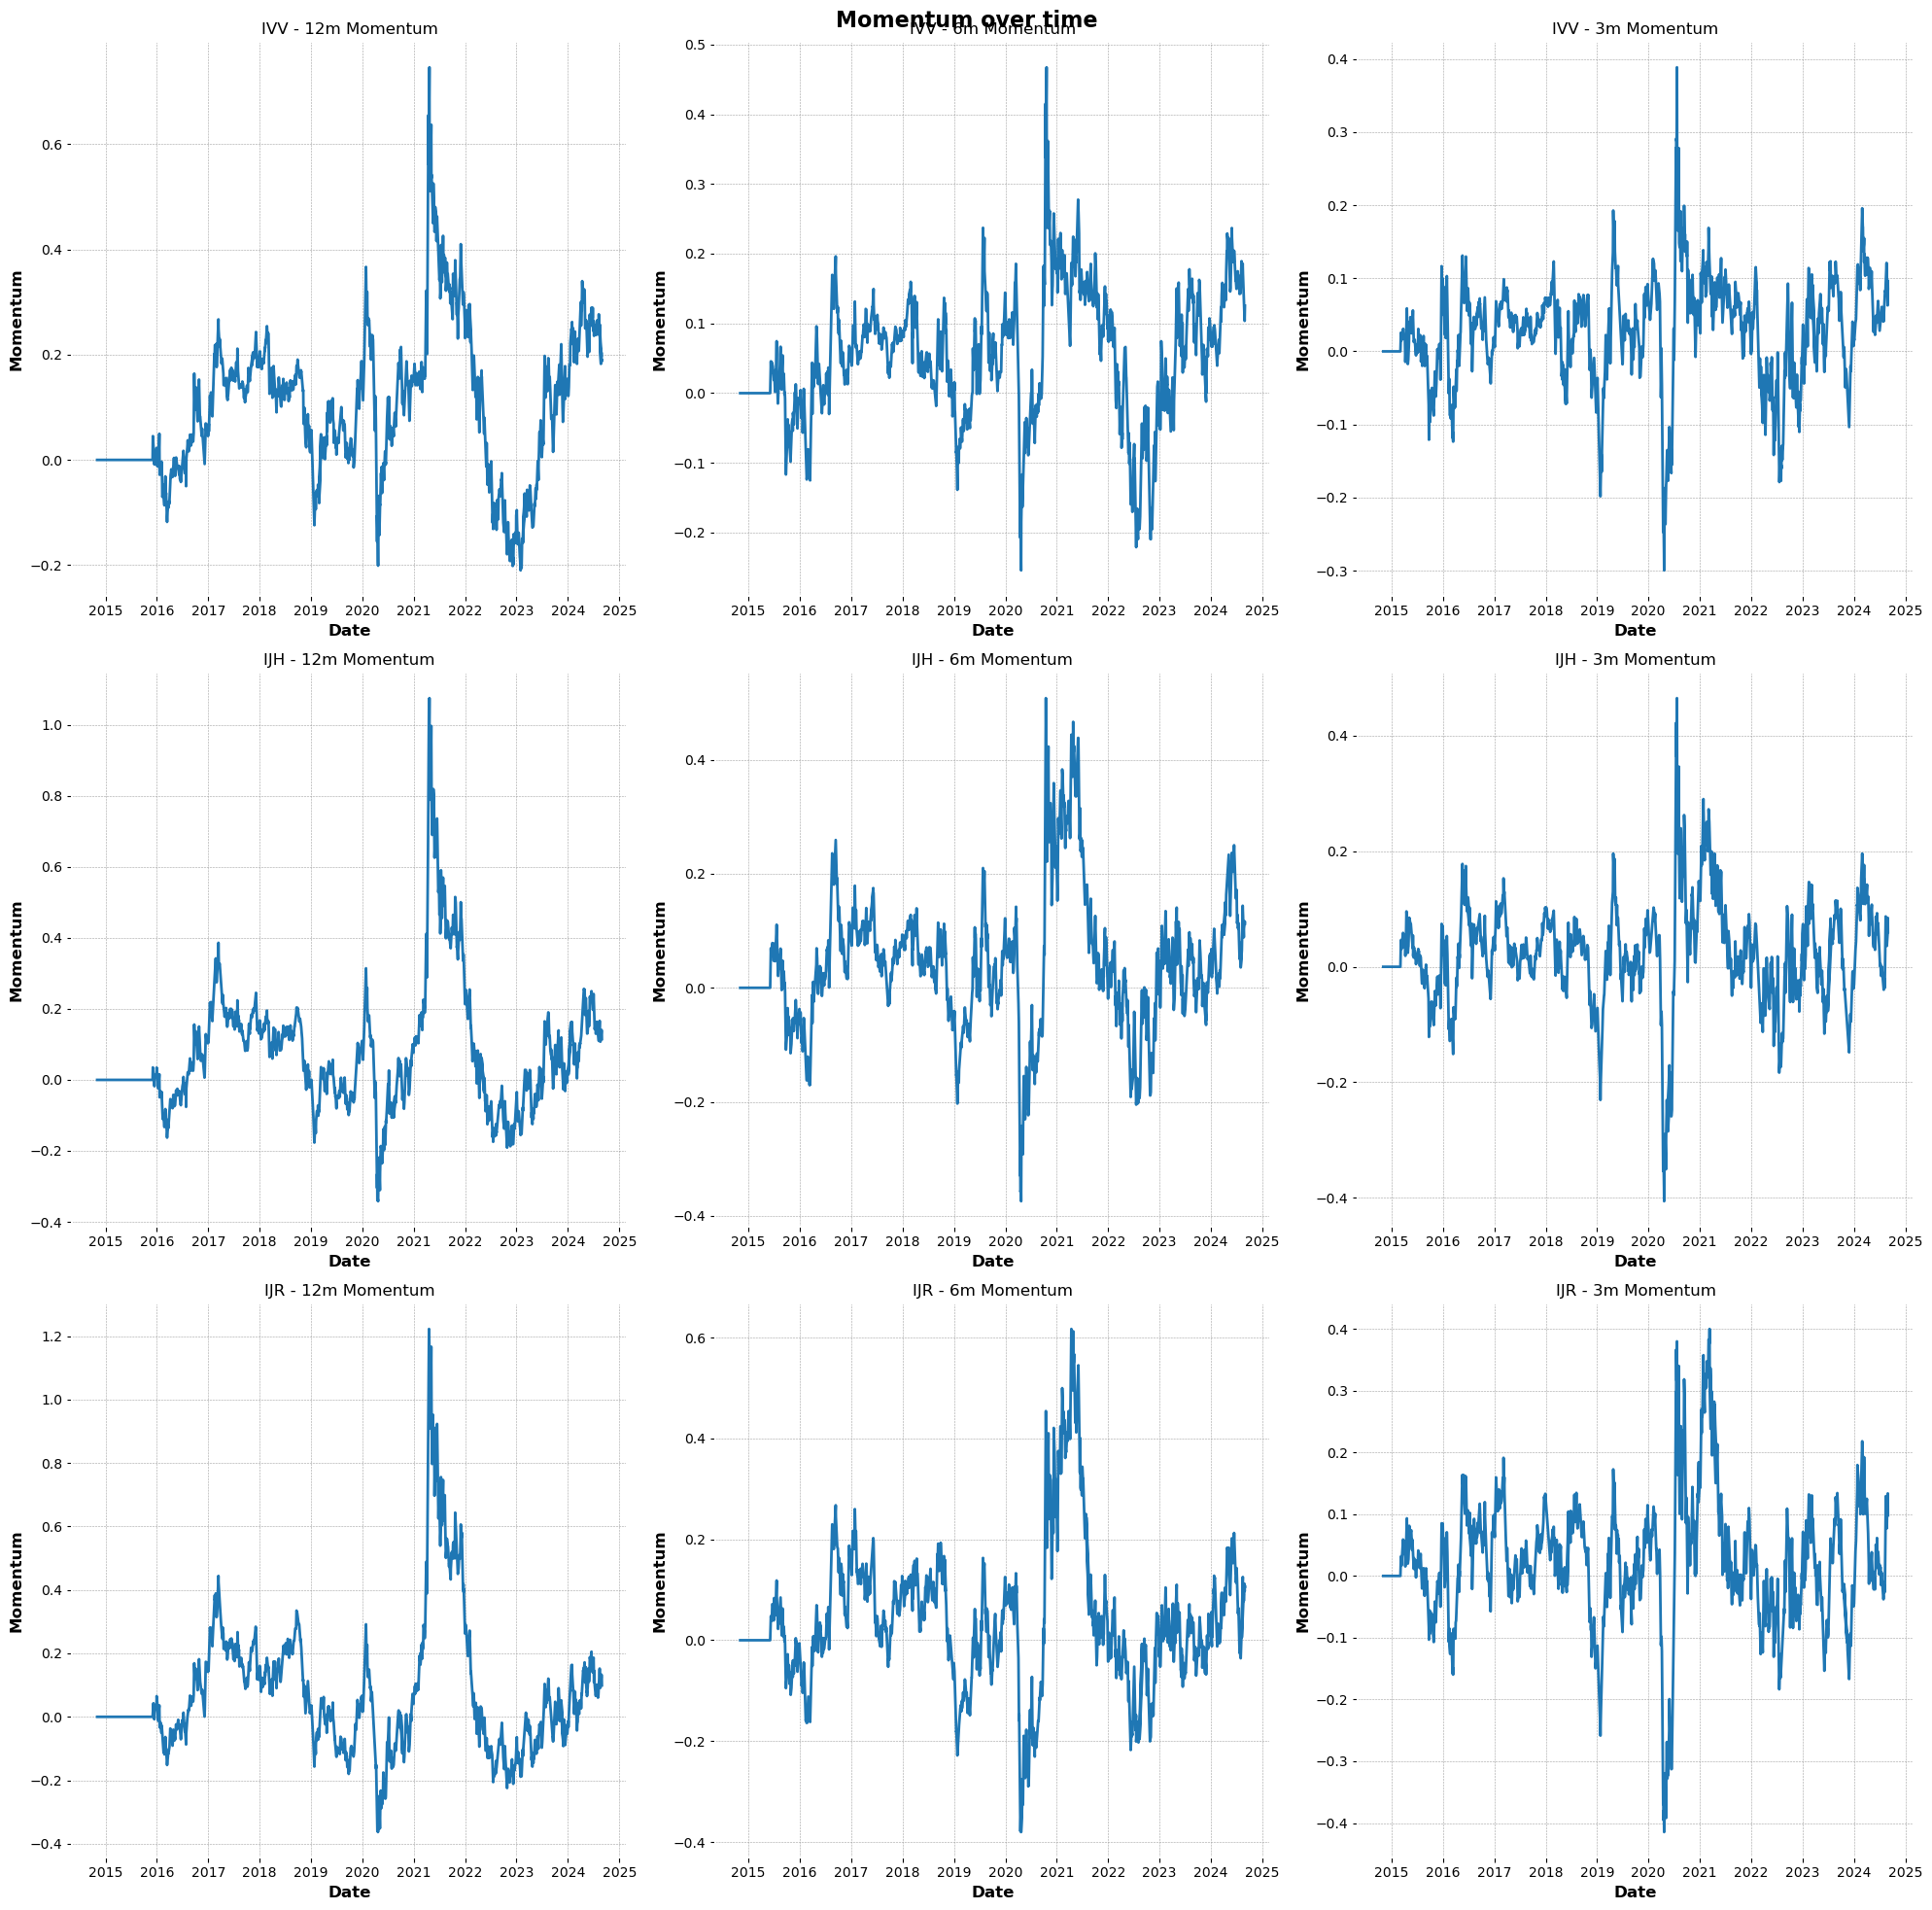

In [38]:
def calculate_momentum(data, column, lookback, skip=21):
    return data[column].pct_change(lookback).shift(skip)

def add_momentum_factors(data):
    datasets = ['ivv', 'ijh', 'ijr']
    lookbacks = {
        '12m': 252,  # Approximately 252 trading days in a year
        '6m': 126,   # Approximately 126 trading days in 6 months
        '3m': 63     # Approximately 63 trading days in 3 months
    }
    
    for dataset in datasets:
        close_column = f'close_{dataset}'
        for period, lookback in lookbacks.items():
            momentum_column = f'momentum_{period}_{dataset}'
            data[momentum_column] = calculate_momentum(data, close_column, lookback)
            data[momentum_column] = data[momentum_column].fillna(0)
    
    return data

# Apply the function to add momentum factors
data = add_momentum_factors(data)

# Print the first few rows of the dataframe to verify
print(data[['Date'] + [col for col in data.columns if 'momentum' in col]].head(10))

# Print summary statistics of the Momentum columns
print("\nMomentum Summary Statistics:")
for col in data.columns:
    if 'momentum' in col:
        print(f"\n{col}:")
        print(data[col].describe())

# Plot momentum over time for each dataset and period
fig, axs = plt.subplots(3, 3, figsize=(20, 20))
fig.suptitle('Momentum over time', fontsize=16)

for i, dataset in enumerate(['ivv', 'ijh', 'ijr']):
    for j, period in enumerate(['12m', '6m', '3m']):
        col = f'momentum_{period}_{dataset}'
        axs[i, j].plot(data['Date'], data[col])
        axs[i, j].set_title(f'{dataset.upper()} - {period} Momentum')
        axs[i, j].set_xlabel('Date')
        axs[i, j].set_ylabel('Momentum')

plt.tight_layout()
plt.show()

In [ ]:
column_names = list(data)
column_names

### 2. Implement the Fama-French 5-Factor Model and Visualize Correlation with Heatmap


Processing IVV:
Columns in the dataframe: ['Date', 'open_ivv', 'high_ivv', 'low_ivv', 'close_ivv', 'Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'RF', 'open_ijh', 'high_ijh', 'low_ijh', 'close_ijh', 'open_ijr', 'high_ijr', 'low_ijr', 'close_ijr', 'momentum_12m_ivv', 'momentum_6m_ivv', 'momentum_3m_ivv', 'momentum_12m_ijh', 'momentum_6m_ijh', 'momentum_3m_ijh', 'momentum_12m_ijr', 'momentum_6m_ijr', 'momentum_3m_ijr']
Rows with NaN values removed: 1
Remaining observations: 2472

Regression results for IVV - Fama-French 5-factor model with Momentum:
                            OLS Regression Results                            
Dep. Variable:      Excess_Return_ivv   R-squared:                       0.993
Model:                            OLS   Adj. R-squared:                  0.993
Method:                 Least Squares   F-statistic:                 4.558e+04
Date:                Tue, 12 Nov 2024   Prob (F-statistic):               0.00
Time:                        14:37:41   Log-Likelihood:   

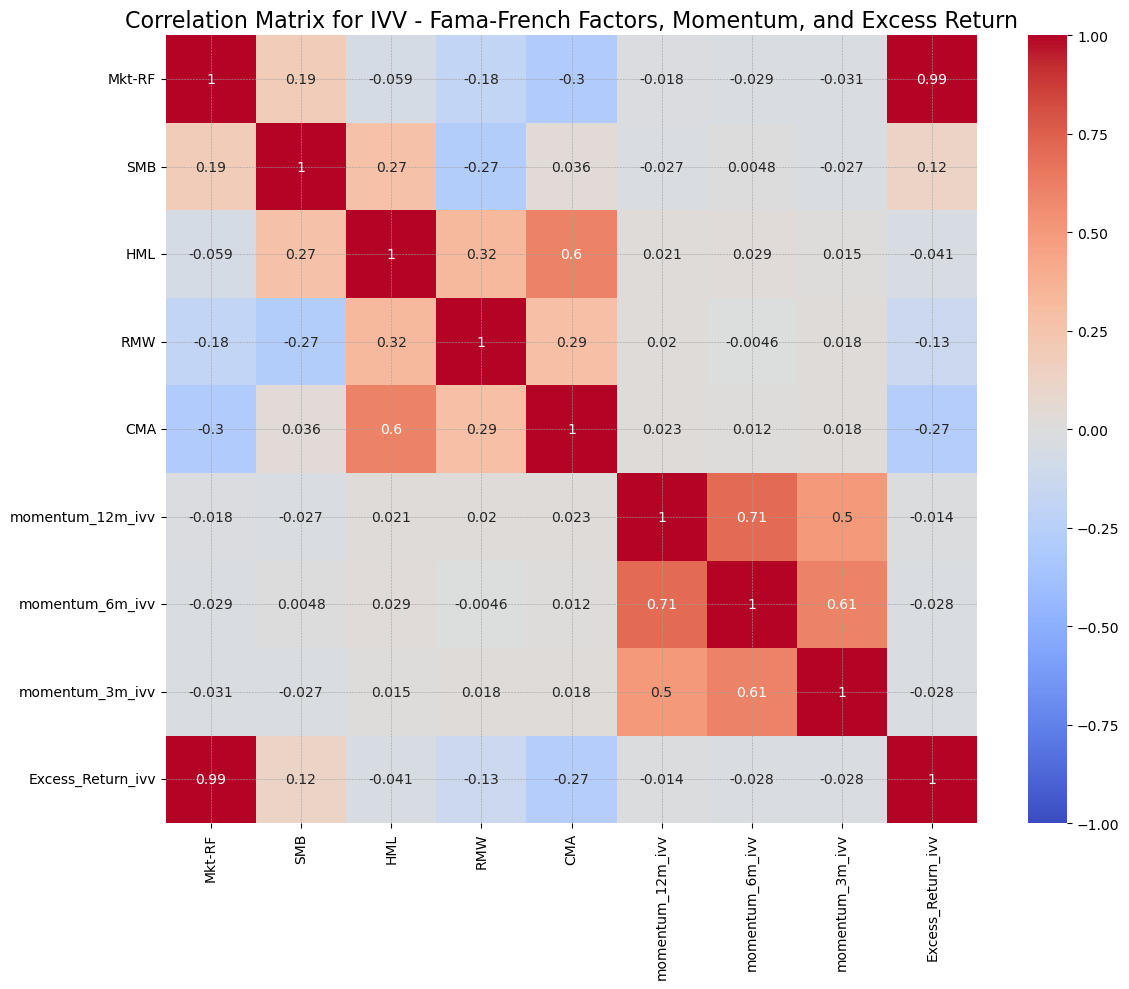


Correlation Matrix:
                     Mkt-RF       SMB       HML       RMW       CMA  \
Mkt-RF             1.000000  0.187874 -0.059027 -0.181638 -0.295437   
SMB                0.187874  1.000000  0.268576 -0.274869  0.036340   
HML               -0.059027  0.268576  1.000000  0.321527  0.603733   
RMW               -0.181638 -0.274869  0.321527  1.000000  0.287101   
CMA               -0.295437  0.036340  0.603733  0.287101  1.000000   
momentum_12m_ivv  -0.018452 -0.027037  0.020935  0.019579  0.023101   
momentum_6m_ivv   -0.028843  0.004848  0.029019 -0.004587  0.012271   
momentum_3m_ivv   -0.030772 -0.026532  0.014652  0.017854  0.017886   
Excess_Return_ivv  0.993253  0.121328 -0.040591 -0.126278 -0.267134   

                   momentum_12m_ivv  momentum_6m_ivv  momentum_3m_ivv  \
Mkt-RF                    -0.018452        -0.028843        -0.030772   
SMB                       -0.027037         0.004848        -0.026532   
HML                        0.020935         0.029

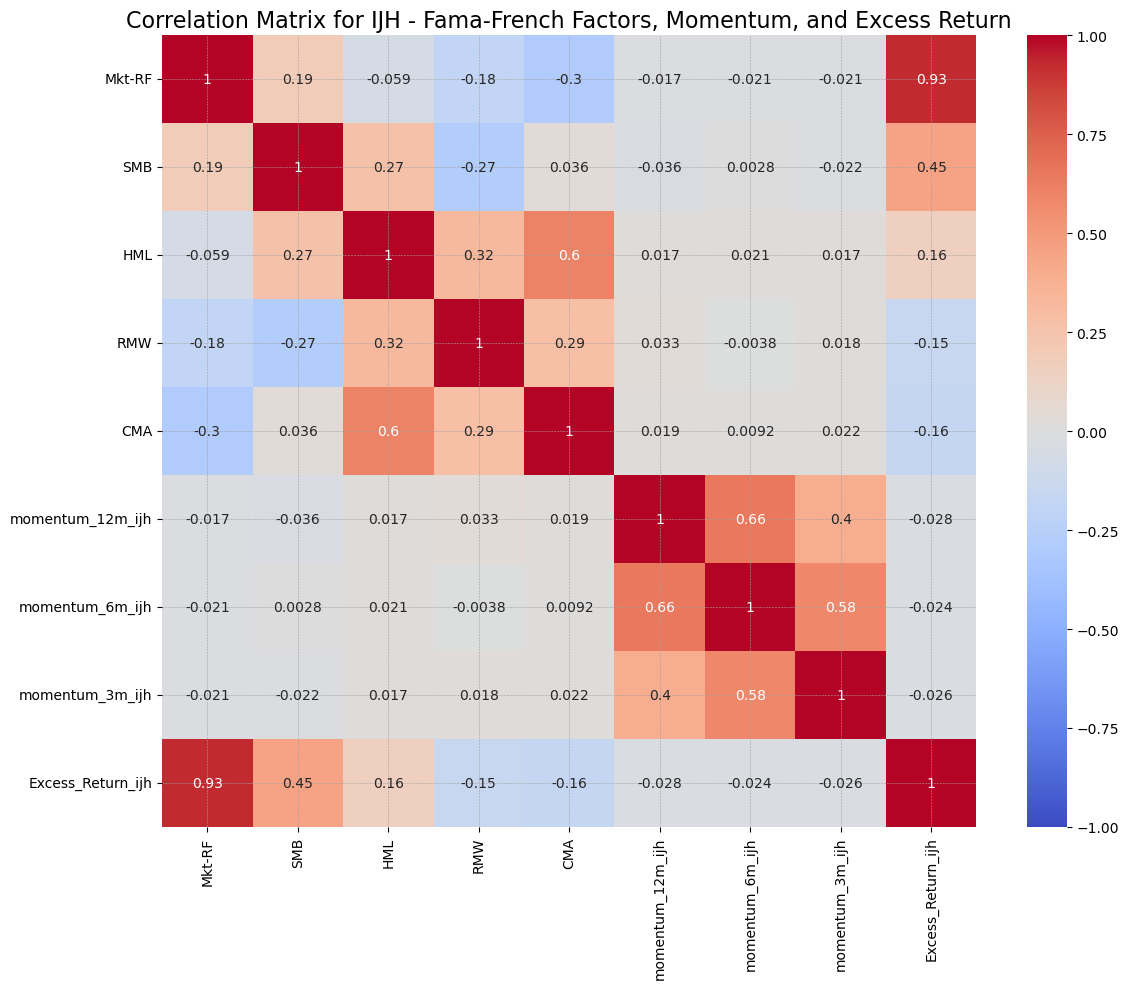


Correlation Matrix:
                     Mkt-RF       SMB       HML       RMW       CMA  \
Mkt-RF             1.000000  0.187874 -0.059027 -0.181638 -0.295437   
SMB                0.187874  1.000000  0.268576 -0.274869  0.036340   
HML               -0.059027  0.268576  1.000000  0.321527  0.603733   
RMW               -0.181638 -0.274869  0.321527  1.000000  0.287101   
CMA               -0.295437  0.036340  0.603733  0.287101  1.000000   
momentum_12m_ijh  -0.017443 -0.036386  0.017065  0.033265  0.018538   
momentum_6m_ijh   -0.021426  0.002760  0.020755 -0.003848  0.009176   
momentum_3m_ijh   -0.021182 -0.021823  0.017470  0.017730  0.021563   
Excess_Return_ijh  0.926186  0.450371  0.160384 -0.154460 -0.164183   

                   momentum_12m_ijh  momentum_6m_ijh  momentum_3m_ijh  \
Mkt-RF                    -0.017443        -0.021426        -0.021182   
SMB                       -0.036386         0.002760        -0.021823   
HML                        0.017065         0.020

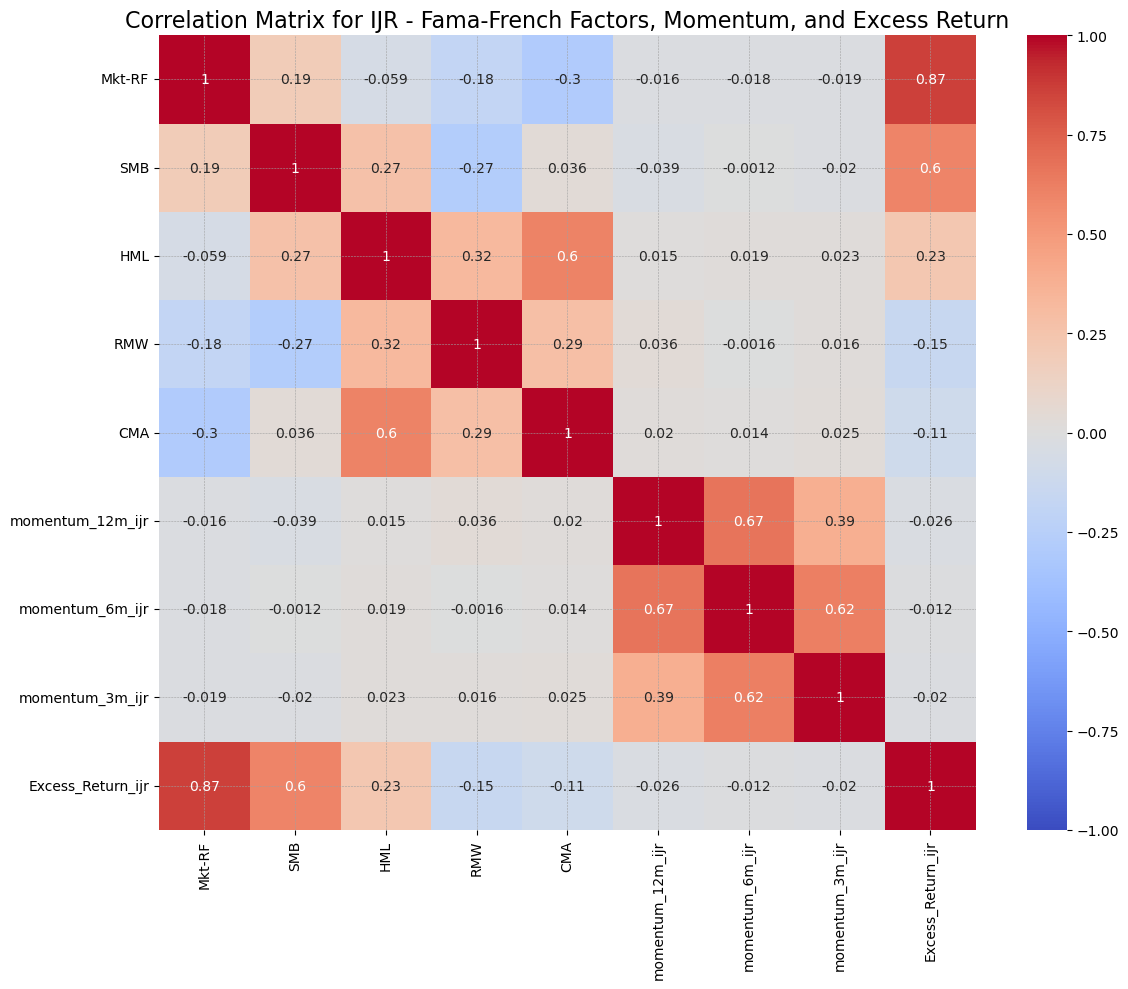


Correlation Matrix:
                     Mkt-RF       SMB       HML       RMW       CMA  \
Mkt-RF             1.000000  0.187874 -0.059027 -0.181638 -0.295437   
SMB                0.187874  1.000000  0.268576 -0.274869  0.036340   
HML               -0.059027  0.268576  1.000000  0.321527  0.603733   
RMW               -0.181638 -0.274869  0.321527  1.000000  0.287101   
CMA               -0.295437  0.036340  0.603733  0.287101  1.000000   
momentum_12m_ijr  -0.015900 -0.038702  0.015149  0.035720  0.020411   
momentum_6m_ijr   -0.017667 -0.001152  0.019065 -0.001619  0.013780   
momentum_3m_ijr   -0.018971 -0.019735  0.022714  0.016421  0.025301   
Excess_Return_ijr  0.866919  0.597016  0.227550 -0.151925 -0.108311   

                   momentum_12m_ijr  momentum_6m_ijr  momentum_3m_ijr  \
Mkt-RF                    -0.015900        -0.017667        -0.018971   
SMB                       -0.038702        -0.001152        -0.019735   
HML                        0.015149         0.019

In [39]:
def compute_excess_return_run_regression_and_create_heatmap(data, fund):
    try:
        # Create a copy of the data to avoid modifying the original dataframe
        df = data.copy()
        
        print(f"\nProcessing {fund.upper()}:")
        print(f"Columns in the dataframe: {df.columns.tolist()}")
        
        # Check if 'Date' column exists
        if 'Date' not in df.columns:
            print("'Date' column is missing. Using the index as the date.")
            df['Date'] = df.index
        
        # Ensure Date is in datetime format and set as index
        df['Date'] = pd.to_datetime(df['Date'])
        df.set_index('Date', inplace=True)

        # Calculate daily returns
        df[f'Daily_Return_{fund}'] = df[f'close_{fund}'].pct_change()

        # Calculate excess returns: fund returns - Risk-free rate
        df[f'Excess_Return_{fund}'] = df[f'Daily_Return_{fund}'] - df['RF'] / 100  # Assuming RF is in percentage

        # Prepare factors for regression and correlation
        factors = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 
                   f'momentum_12m_{fund}', f'momentum_6m_{fund}', f'momentum_3m_{fund}',
                   f'Excess_Return_{fund}']

        # Check for NaN values in relevant columns
        nan_count_before = df[factors].isnull().sum().sum()
        df = df.dropna(subset=factors)
        nan_count_after = df[factors].isnull().sum().sum()

        print(f"Rows with NaN values removed: {nan_count_before - nan_count_after}")
        print(f"Remaining observations: {len(df)}")

        # Regression analysis
        X = df[factors[:-1]]  # All factors except Excess_Return
        y = df[f'Excess_Return_{fund}']
        
        X = sm.add_constant(X)  # Add constant term

        # Run OLS regression
        model = sm.OLS(y, X).fit()
        
        print(f"\nRegression results for {fund.upper()} - Fama-French 5-factor model with Momentum:")
        print(model.summary())

        # Create correlation heatmap
        corr_matrix = df[factors].corr()
        
        plt.figure(figsize=(12, 10))
        sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
        plt.title(f'Correlation Matrix for {fund.upper()} - Fama-French Factors, Momentum, and Excess Return', fontsize=16)
        plt.tight_layout()
        plt.show()

        print("\nCorrelation Matrix:")
        print(corr_matrix)

        print(f"\nHighly correlated factors for {fund.upper()} (|correlation| > 0.5):")
        for i in range(len(factors)):
            for j in range(i+1, len(factors)):
                if abs(corr_matrix.iloc[i, j]) > 0.5:
                    print(f"{factors[i]} and {factors[j]}: {corr_matrix.iloc[i, j]:.2f}")

    except Exception as e:
        print(f"Error processing data for {fund}: {str(e)}")
        print(f"Error type: {type(e).__name__}")
        print(f"Error details: {e.args}")
        print("DataFrame info:")
        print(df.info())

# Run the computation, regression, and create heatmap for each fund
for fund in ['ivv', 'ijh', 'ijr']:
    compute_excess_return_run_regression_and_create_heatmap(data, fund)

### 3. Data Analysis

##### 3.1 Performance analysis

Risk-adjusted returns

In [40]:
def calculate_performance_metrics(data, fund):
    try:
        # Create a copy of the data to avoid modifying the original dataframe
        df = data.copy()

        # Ensure Date is in datetime format and set as index
        df['Date'] = pd.to_datetime(df['Date'])
        df.set_index('Date', inplace=True)

        # Calculate daily returns for the fund
        df[f'Daily_Return_{fund}'] = df[f'close_{fund}'].pct_change()

        # Calculate excess returns: fund returns - Risk-free rate
        df[f'Excess_Return_{fund}'] = df[f'Daily_Return_{fund}'] - df['RF'] / 100  # Assuming RF is in percentage

        # Calculate average daily return and standard deviation of daily returns
        avg_daily_return = df[f'Daily_Return_{fund}'].mean()
        std_daily_return = df[f'Daily_Return_{fund}'].std()
        
        # Calculate annualized metrics
        risk_free_rate = df['RF'].mean() / 100  # Convert to decimal
        annualized_return = (1 + avg_daily_return) ** 252 - 1
        annualized_volatility = std_daily_return * np.sqrt(252)
        
        # Cumulative return
        cumulative_return = (1 + df[f'Daily_Return_{fund}']).cumprod() - 1
        
        # 1. Annualized Return
        print(f"\nPerformance Metrics for {fund.upper()}:")
        print(f"1. Annualized Return: {annualized_return:.4f}")
        
        # 2. Cumulative Return
        print(f"2. Cumulative Return: {cumulative_return.iloc[-1]:.4f}")

        # 3. Annualized Volatility
        print(f"3. Annualized Volatility: {annualized_volatility:.4f}")

        # 4. Sharpe Ratio
        sharpe_ratio = (avg_daily_return - risk_free_rate) / std_daily_return if std_daily_return != 0 else np.nan
        print(f"4. Sharpe Ratio: {sharpe_ratio:.4f}")
        
        # 5. Sortino Ratio (using downside deviation)
        downside_returns = df[f'Daily_Return_{fund}'][df[f'Daily_Return_{fund}'] < 0]
        downside_deviation = np.sqrt((downside_returns**2).mean())
        sortino_ratio = (avg_daily_return - risk_free_rate) / downside_deviation if downside_deviation != 0 else np.nan
        print(f"5. Sortino Ratio: {sortino_ratio:.4f}")
        
        # 6. Treynor Ratio (assuming market return is the average of Mkt-RF)
        market_return = df['Mkt-RF'].mean() / 100  # Convert to decimal
        treynor_ratio = (annualized_return - risk_free_rate) / market_return if market_return != 0 else np.nan
        print(f"6. Treynor Ratio: {treynor_ratio:.4f}")
        
        # 7. Alpha using CAPM: α = R_fund - [R_free + β * (R_market - R_free)]
        X = sm.add_constant(df['Mkt-RF'])  # Adding constant for regression
        model = sm.OLS(df[f'Daily_Return_{fund}'], X).fit()
        beta = model.params[1]  # Beta is the slope coefficient for Mkt-RF
        alpha = avg_daily_return - (risk_free_rate + beta * (market_return - risk_free_rate))
        print(f"7. Alpha: {alpha:.4f}")
        
        # 8. Information Ratio: Excess return relative to tracking error
        tracking_error = np.sqrt(((df[f'Excess_Return_{fund}'] - (df['Mkt-RF'])).dropna())**2).mean()
        information_ratio = (avg_daily_return - market_return) / tracking_error if tracking_error != 0 else np.nan
        print(f"8. Information Ratio: {information_ratio:.4f}")
        
        # 9. M2 Measure (Modigliani Measure)
        m2_measure = ((annualized_volatility / std_daily_return) * (annualized_return - risk_free_rate)) + risk_free_rate
        print(f"9. M2 Measure: {m2_measure:.4f}")

    except Exception as e:
        print(f"Error processing data for {fund}: {str(e)}")
        print(f"Error type: {type(e).__name__}")
        print(f"Error details: {e.args}")

# Run performance metrics calculation for each fund
for fund in ['ivv', 'ijh', 'ijr']:
    calculate_performance_metrics(data, fund)


Performance Metrics for IVV:
1. Annualized Return: 0.1284
2. Cumulative Return: 1.7904
3. Annualized Volatility: 0.1795
4. Sharpe Ratio: 0.0370
5. Sortino Ratio: 0.0350
6. Treynor Ratio: 266.9892
7. Alpha: nan
8. Information Ratio: -0.0000
9. M2 Measure: 2.0370

Performance Metrics for IJH:
1. Annualized Return: 0.1065
2. Cumulative Return: 1.1806
3. Annualized Volatility: 0.2076
4. Sharpe Ratio: 0.0260
5. Sortino Ratio: 0.0246
6. Treynor Ratio: 221.4205
7. Alpha: nan
8. Information Ratio: -0.0001
9. M2 Measure: 1.6893

Performance Metrics for IJR:
1. Annualized Return: 0.1056
2. Cumulative Return: 1.0916
3. Annualized Volatility: 0.2240
4. Sharpe Ratio: 0.0239
5. Sortino Ratio: 0.0232
6. Treynor Ratio: 219.6964
7. Alpha: nan
8. Information Ratio: -0.0001
9. M2 Measure: 1.6762


Factor-Adjusted Performance

In [41]:
# Compute Fama-French Alpha for each fund
def calculate_fama_french_alpha(data, fund):
    try:
        # Create a copy of the data to avoid modifying the original dataframe
        df = data.copy()

        # Ensure Date is in datetime format and set as index
        df['Date'] = pd.to_datetime(df['Date'])
        df.set_index('Date', inplace=True)

        # Calculate daily returns for the fund
        df[f'Daily_Return_{fund}'] = df[f'close_{fund}'].pct_change()

        # Calculate excess returns: fund returns - risk-free rate
        df[f'Excess_Return_{fund}'] = df[f'Daily_Return_{fund}'] - df['RF'] / 100  # Assuming RF is in percentage

        # Prepare factors for regression
        X = df[['Mkt-RF', 'SMB', 'HML']].dropna()  # Independent variables
        y = df[f'Excess_Return_{fund}'].dropna()   # Dependent variable

        # Align X and y to ensure they have the same index after dropping NaN values
        common_index = X.index.intersection(y.index)
        X = X.loc[common_index]
        y = y.loc[common_index]

        # Add constant term for regression
        X = sm.add_constant(X)

        # Run OLS regression
        model = sm.OLS(y, X).fit()

        # Extract alpha (intercept)
        alpha = model.params['const']
        
        print(f"\nFama-French Alpha for {fund.upper()}: {alpha:.4f}")

    except Exception as e:
        print(f"Error processing data for {fund}: {str(e)}")
        print(f"Error type: {type(e).__name__}")
        print(f"Error details: {e.args}")

# Run Fama-French Alpha calculation for each fund
for fund in ['ivv', 'ijh', 'ijr']:
    calculate_fama_french_alpha(data, fund)


Fama-French Alpha for IVV: -0.0001

Fama-French Alpha for IJH: -0.0001

Fama-French Alpha for IJR: -0.0001


##### 3.2 Robustness Check

Time-Varying Factor Exposures

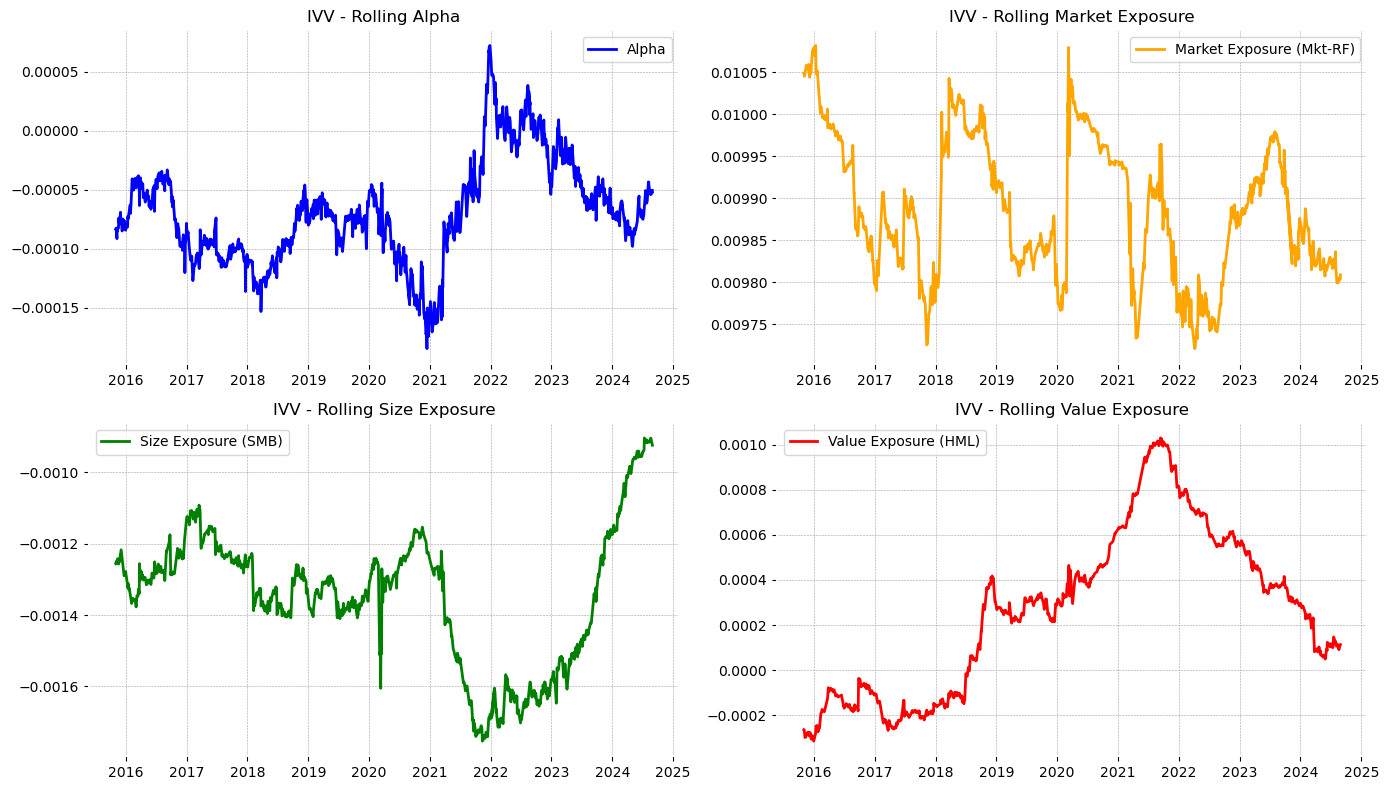

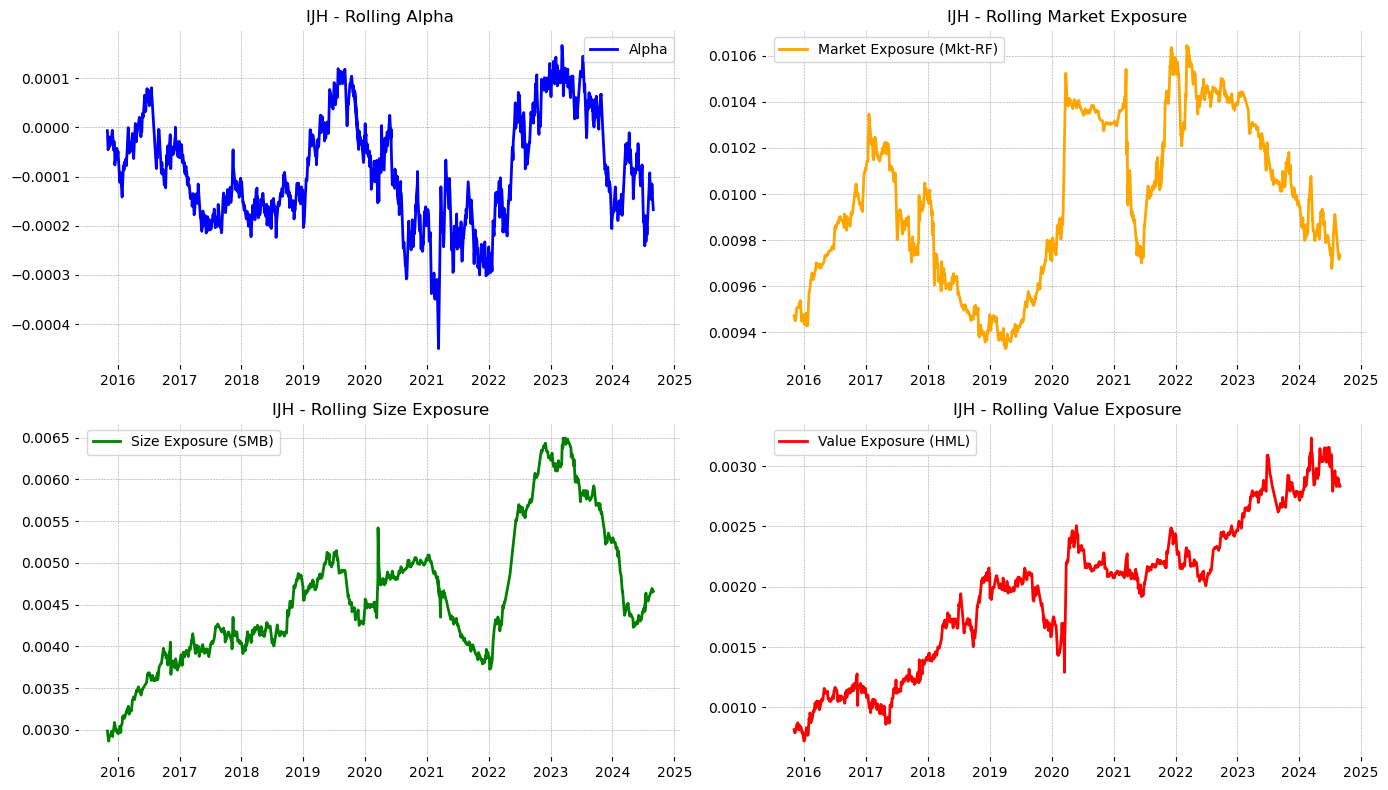

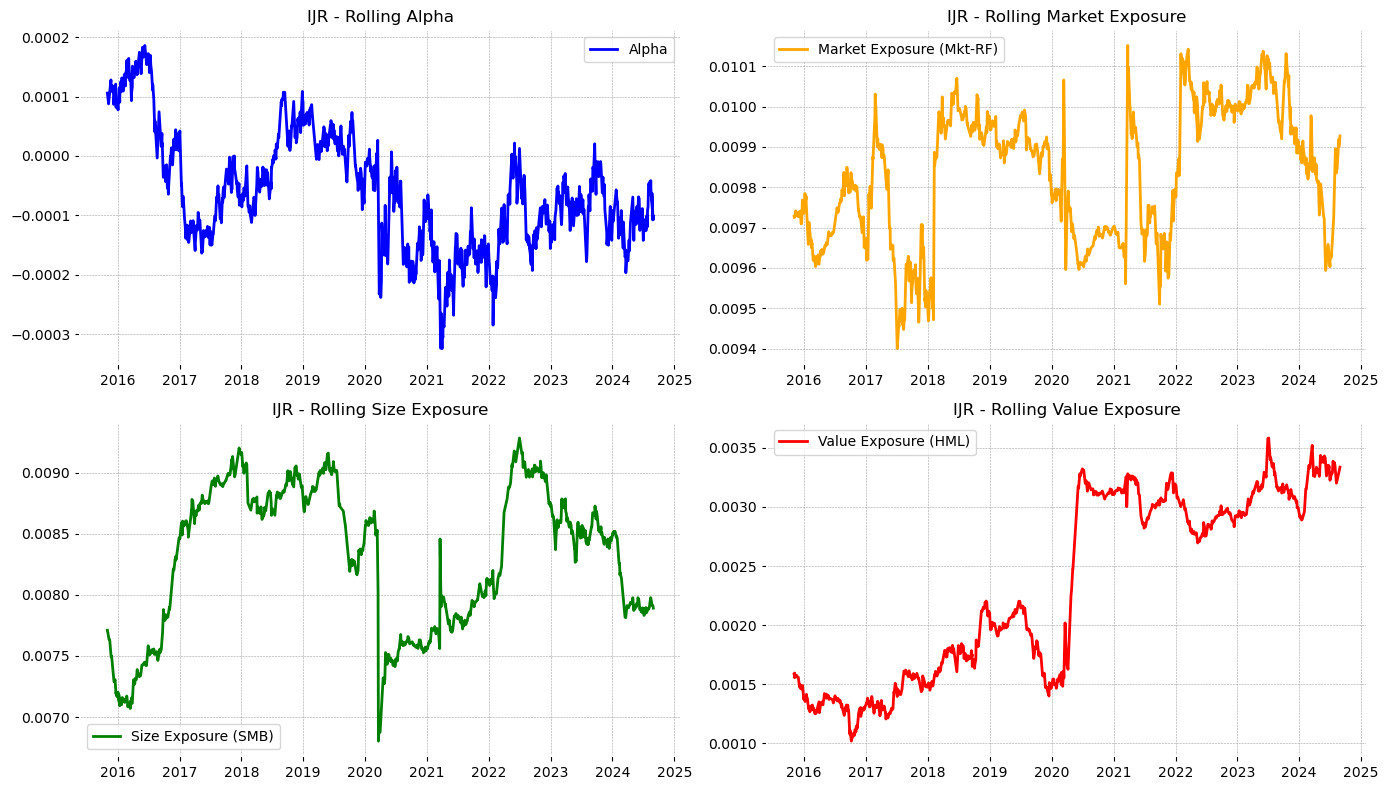

In [ ]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

def rolling_regression(data, fund, window=252):
    try:
        # Create a copy of the data to avoid modifying the original dataframe
        df = data.copy()

        # Ensure Date is in datetime format and set as index
        df['Date'] = pd.to_datetime(df['Date'])
        df.set_index('Date', inplace=True)

        # Calculate daily returns for the fund
        df[f'Daily_Return_{fund}'] = df[f'close_{fund}'].pct_change()

        # Calculate excess returns: fund returns - risk-free rate
        df[f'Excess_Return_{fund}'] = df[f'Daily_Return_{fund}'] - df['RF'] / 100  # Assuming RF is in percentage

        # Prepare factors for regression
        factors = ['Mkt-RF', 'SMB', 'HML']
        
        # Store results in a DataFrame
        results = pd.DataFrame(index=df.index)

        # Perform rolling regression
        for start in range(len(df) - window):
            end = start + window
            rolling_window_data = df.iloc[start:end]

            # Prepare X and y for regression
            X = rolling_window_data[factors].dropna()
            y = rolling_window_data[f'Excess_Return_{fund}'].dropna()

            # Ensure X and y have matching indices after dropping NaN values
            common_index = X.index.intersection(y.index)
            X = X.loc[common_index]
            y = y.loc[common_index]

            if len(y) > 0:  # Check if there are enough data points for regression
                X_with_const = sm.add_constant(X)
                model = sm.OLS(y, X_with_const).fit()
                results.loc[rolling_window_data.index[-1], 'Alpha'] = model.params['const']
                results.loc[rolling_window_data.index[-1], 'Mkt-RF'] = model.params['Mkt-RF']
                results.loc[rolling_window_data.index[-1], 'SMB'] = model.params['SMB']
                results.loc[rolling_window_data.index[-1], 'HML'] = model.params['HML']

        # Plotting the results of the rolling regression analysis
        plt.figure(figsize=(14, 8))
        plt.subplot(2, 2, 1)
        plt.plot(results['Alpha'], label='Alpha', color='blue')
        plt.title(f'{fund.upper()} - Rolling Alpha')
        plt.legend()

        plt.subplot(2, 2, 2)
        plt.plot(results['Mkt-RF'], label='Market Exposure (Mkt-RF)', color='orange')
        plt.title(f'{fund.upper()} - Rolling Market Exposure')
        plt.legend()

        plt.subplot(2, 2, 3)
        plt.plot(results['SMB'], label='Size Exposure (SMB)', color='green')
        plt.title(f'{fund.upper()} - Rolling Size Exposure')
        plt.legend()

        plt.subplot(2, 2, 4)
        plt.plot(results['HML'], label='Value Exposure (HML)', color='red')
        plt.title(f'{fund.upper()} - Rolling Value Exposure')
        plt.legend()

        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"Error processing data for {fund}: {str(e)}")
        print(f"Error type: {type(e).__name__}")
        print(f"Error details: {e.args}")

# Run rolling regression analysis for each fund with a specified window size (e.g., 252 trading days)
for fund in ['ivv', 'ijh', 'ijr']:
    rolling_regression(data, fund, window=252)